In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('SPY', start='2016-01-01', end='2022-02-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,177.237396,222353500
2016-01-05,201.399994,201.899994,200.050003,201.360001,177.537140,110845800
2016-01-06,198.339996,200.059998,197.600006,198.820007,175.297684,152112600
2016-01-07,195.330002,197.440002,193.589996,194.050003,171.092056,213436100
2016-01-08,195.190002,195.850006,191.580002,191.919998,169.214020,209817200


Text(0, 0.5, 'Prices ($)')

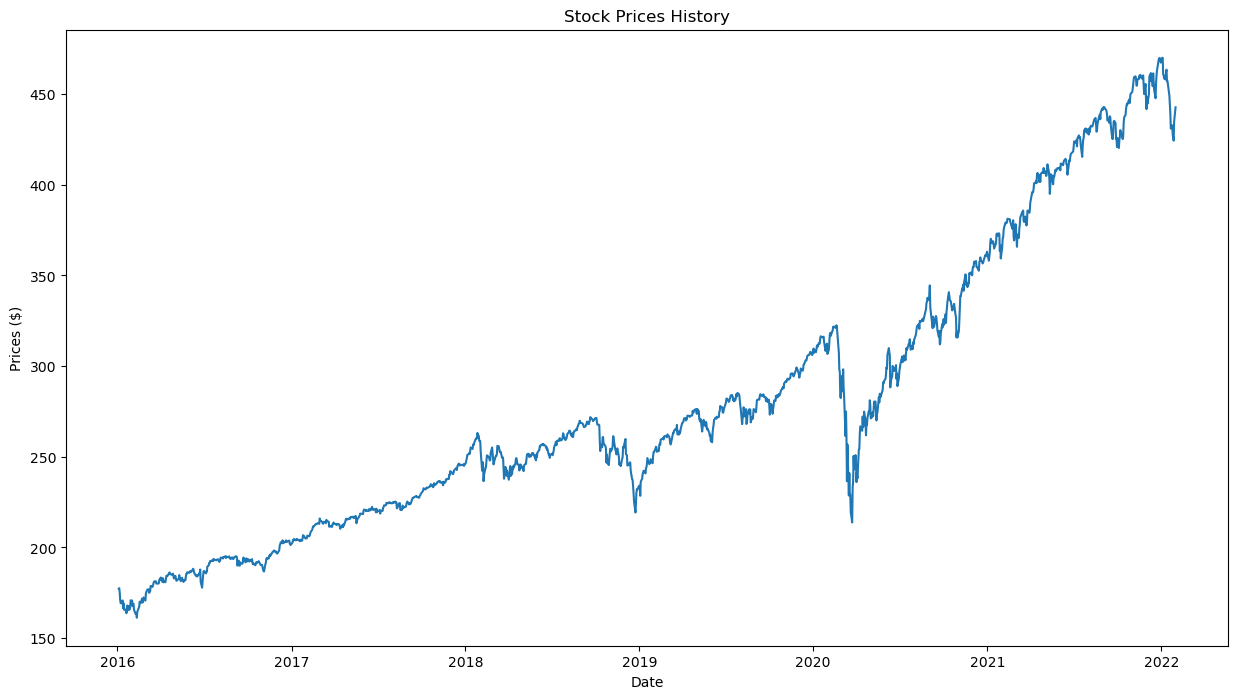

In [2]:

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [3]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [6]:

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1165/1165 [==============================] - 21s 17ms/step - loss: 9.9682e-04
Epoch 2/3
1165/1165 [==============================] - 27s 24ms/step - loss: 4.5546e-04
Epoch 3/3
1165/1165 [==============================] - 25s 22ms/step - loss: 3.4638e-04


In [7]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:', rmse)
print('% Error', 100 * rmse / predictions.max())
y_test

10/10 [==============================] - 1s 16ms/step
RMSE: 11.755328209571589
% Error 2.541086287815894


array([353.20999146, 358.1000061 , 362.57000732, 360.61999512,
       356.27999878, 357.77999878, 355.32998657, 357.45999146,
       363.22000122, 362.66000366, 363.67001343, 362.05999756,
       366.01998901, 366.79000854, 366.69000244, 369.8500061 ,
       369.08999634, 370.17001343, 366.8500061 , 366.73001099,
       366.29998779, 364.66000366, 369.58999634, 370.17001343,
       372.23999023, 369.17999268, 367.85998535, 367.23999023,
       367.57000732, 369.        , 372.17001343, 371.45999146,
       371.98999023, 373.88000488, 368.79000854, 371.32998657,
       373.54998779, 379.1000061 , 381.26000977, 378.69000244,
       378.76998901, 379.79000854, 378.45999146, 375.70001221,
       378.6499939 , 383.89001465, 384.23999023, 382.88000488,
       384.39001465, 383.79000854, 374.41000366, 377.63000488,
       370.07000732, 376.23001099, 381.54998779, 381.8500061 ,
       386.19000244, 387.70999146, 390.51000977, 390.25      ,
       390.07998657, 390.70999146, 392.64001465, 392.29

C:\Users\gupta\AppData\Local\Temp\ipykernel_12692\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


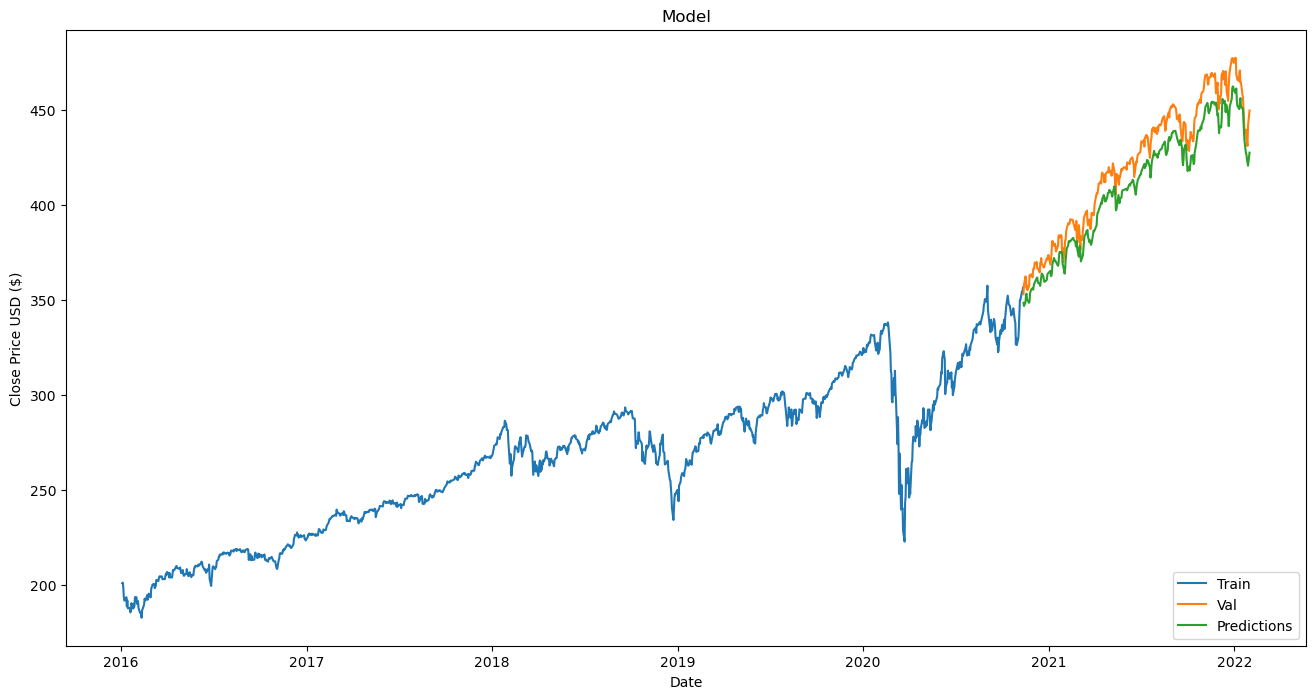

In [8]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [9]:
suc = 0
suc1 = 0
suc2 = 0
tot = 0
for i in range(1, len(predictions)):
    #print(predictions[i][0])
    #print(i, predictions[i][0] - y_test[i], y_test[i] - y_test[i-1] > 0)
    tot += 1
    if predictions[i][0]  > .93 * y_test[i] and predictions[i][0] < 1.03 * y_test[i]:
        suc += 1
print(suc1)
print(suc2)
print(suc)
print(tot)
for i in range(10):
    print(predictions[i][0], y_test[i])
y_test
predictions[1][0]
#print('accuracy %:', suc * 100 / tot)

validation_array = [[0, 0], [0, 0]]
total_vals_1 = 0
for i in range(1, len(predictions)):
    #print(predictions[i][0])
    #print(i, predictions[i][0] - y_test[i], y_test[i] - y_test[i-1] > 0)
    total_vals_1 += 1
    if predictions[i][0] - predictions[i-1][0] >= 0:
        if y_test[i] - y_test[i-1] >= -1 * .01 * y_test[i]:
            validation_array[1][1] += 1
        else:
            validation_array[1][0] += 1
    else:
        if y_test[i] - y_test[i-1] <= .01 * y_test[i]:
            validation_array[0][0] += 1
        else:
            validation_array[0][1] += 1
print('% Accuracy', 100 * (validation_array[0][0] +  validation_array[1][1])/total_vals_1, '%') 
validation_array

# Used on Close Column: % Accuracy 89.18032786885246 %

0
0
305
305
348.696 353.2099914550781
346.99234 358.1000061035156
348.9311 362.57000732421875
352.8998 360.6199951171875
353.50858 356.2799987792969
350.64633 357.7799987792969
350.04343 355.3299865722656
348.68265 357.4599914550781
349.51846 363.2200012207031
353.76608 362.6600036621094
% Accuracy 88.85245901639344 %


[[104, 22], [12, 167]]

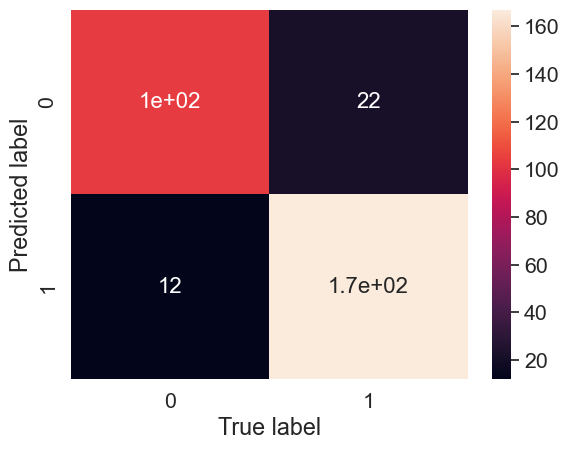

In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(validation_array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.ylabel('Predicted label')
plt.xlabel('True label')
plt.show()

In [11]:
max_inaccuracy = 0
for i in range(1, len(predictions)):
    max_inaccuracy = max(max_inaccuracy, abs(predictions[i][0] - y_test[i]) * 100 / y_test[i])
max_inaccuracy

5.11385146004793

In [12]:
#Round off Values
#Creating Boxes
#Take Adjusted Close
#Year-based Accuracy
#Multivariate LSTM

In [13]:
stock = ['^RUT', '^GSPC', '^DJI', '^IXIC' ]
data = yf.download(stock, start='2016-01-01', end='2022-02-01')
print(data.head())

[*********************100%***********************]  4 of 4 completed
               Adj Close                                                Close  \
                    ^DJI        ^GSPC        ^IXIC         ^RUT          ^DJI   
Date                                                                            
2016-01-04  17148.939453  2012.660034  4903.089844  1108.619995  17148.939453   
2016-01-05  17158.660156  2016.709961  4891.430176  1110.439941  17158.660156   
2016-01-06  16906.509766  1990.260010  4835.759766  1094.369995  16906.509766   
2016-01-07  16514.099609  1943.089966  4689.430176  1064.569946  16514.099609   
2016-01-08  16346.450195  1922.030029  4643.629883  1046.199951  16346.450195   

                                                           High               \
                  ^GSPC        ^IXIC         ^RUT          ^DJI        ^GSPC   
Date                                                                           
2016-01-04  2012.660034  4903.089844  1108

In [14]:
X = data.copy()
print(X.shape)
print(X.tail())
X = X['Close']
X

(1531, 24)
               Adj Close                                          \
                    ^DJI        ^GSPC         ^IXIC         ^RUT   
Date                                                               
2022-01-25  34297.730469  4356.450195  13539.290039  2004.030029   
2022-01-26  34168.089844  4349.930176  13542.120117  1976.459961   
2022-01-27  34160.781250  4326.509766  13352.780273  1931.290039   
2022-01-28  34725.468750  4431.850098  13770.570312  1968.510010   
2022-01-31  35131.859375  4515.549805  14239.879883  2028.449951   

                   Close                                          \
                    ^DJI        ^GSPC         ^IXIC         ^RUT   
Date                                                               
2022-01-25  34297.730469  4356.450195  13539.290039  2004.030029   
2022-01-26  34168.089844  4349.930176  13542.120117  1976.459961   
2022-01-27  34160.781250  4326.509766  13352.780273  1931.290039   
2022-01-28  34725.468750  4431.85009

,^DJI,^GSPC,^IXIC,^RUT
Date,,,,
2016-01-04,17148.939453,2012.660034,4903.089844,1108.619995
2016-01-05,17158.660156,2016.709961,4891.430176,1110.439941
2016-01-06,16906.509766,1990.260010,4835.759766,1094.369995
2016-01-07,16514.099609,1943.089966,4689.430176,1064.569946
2016-01-08,16346.450195,1922.030029,4643.629883,1046.199951
...,...,...,...,...
2022-01-25,34297.730469,4356.450195,13539.290039,2004.030029
2022-01-26,34168.089844,4349.930176,13542.120117,1976.459961
2022-01-27,34160.781250,4326.509766,13352.780273,1931.290039


In [15]:
X.corr()

,^DJI,^GSPC,^IXIC,^RUT
^DJI,1.000000,0.978885,0.953727,0.942926
^GSPC,0.978885,1.000000,0.989728,0.938582
^IXIC,0.953727,0.989728,1.000000,0.918060
^RUT,0.942926,0.938582,0.918060,1.000000


In [16]:
split_ratio = 0.2
X = X.values # Convert to NumPy array
split = int(len(X) * (1-split_ratio))
train_set = X[: split]
test_set = X[split:]
print(train_set.shape, test_set.shape)

(1224, 4) (307, 4)


In [17]:
def supvervisedSeries(data, n, h):
  x, y = list (), list ()
  for i in range (len(data)-n-h+1):
    x.append(data[i:(i+n)])
    y.append(data[i+h+n-1])
  return np.array(x), np.array(y)
h = 1
n = 4
trainX, trainY = supvervisedSeries(train_set, n, h)
testX, testY = supvervisedSeries(test_set, n, h)
print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY: ", testY.shape)

trainX:  (1220, 4, 4)
trainY:  (1220, 4)
testX:  (303, 4, 4)
testY:  (303, 4)


In [18]:
scalers = {}
for i in range (trainX.shape[2]):
  scalers[i] = MinMaxScaler()
  trainX[:, :, i] = scalers[i].fit_transform(trainX[:, :, i])
for i in range(testX.shape[2]):
  testX[:, :, i] = scalers[i].transform(testX[:, :, i])
# The target values are 2D arrays, which is easy to scale
scalerY = MinMaxScaler()
trainY = scalerY.fit_transform(trainY)
testY = scalerY.transform(testY)

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import Sequential

ImportError: cannot import name 'Sequential' from 'tensorflow' (C:\Users\gupta\anaconda3\lib\site-packages\tensorflow\__init__.py)

In [ ]:
print(trainX.shape)
# Flatten input (to support multivariate input)
n_input = trainX.shape[1]
trainX = trainX.reshape((trainX.shape[0], n_input))
n_input = testX.shape[1]
testX = testX.reshape((testX.shape[0], n_input))
# Create multilayered FFNN model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=trainX.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(trainY.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
# Fit model
history = model.fit(trainX, trainY, epochs =60, verbose =1)
# Predict the test set
predictions = model.predict(testX)
